**Визуализация и Кластеризация данных: Отчет по мировым показателям счастья.**

Показана базовая визуализация с использованием карты хороплет. Далее произведена кластеризация с использованием алгоритма k-means на нескольких факторах, таких как ВВП на душу населения, ожидаемая продолжительность жизни, коррупция и так далее. Данные взяты за 2017 год.  

In [226]:
#Call required libraries
import time                   # To time processes
import warnings               # To suppress warnings

import numpy as np            # Data manipulation
import pandas as pd           # Dataframe manipulatio 
import matplotlib.pyplot as plt                   # For graphics
import seaborn as sns
import plotly.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys                    # For data size


In [227]:
wh = pd.read_csv("../input/2017.csv") #Read the dataset
wh.describe()

,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,78.000000,5.354019,5.452326,5.255713,0.984718,1.188898,0.551341,0.408786,0.246883,0.123120,1.850238
std,44.888751,1.131230,1.118542,1.145030,0.420793,0.287263,0.237073,0.149997,0.134780,0.101661,0.500028
min,1.000000,2.693000,2.864884,2.521116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377914
25%,39.500000,4.505500,4.608172,4.374955,0.663371,1.042635,0.369866,0.303677,0.154106,0.057271,1.591291
50%,78.000000,5.279000,5.370032,5.193152,1.064578,1.253918,0.606042,0.437454,0.231538,0.089848,1.832910
75%,116.500000,6.101500,6.194600,6.006527,1.318027,1.414316,0.723008,0.516561,0.323762,0.153296,2.144654
max,155.000000,7.537000,7.622030,7.479556,1.870766,1.610574,0.949492,0.658249,0.838075,0.464308,3.117485


In [228]:
print("Dimension of dataset: wh.shape")
wh.dtypes

Dimension of dataset: wh.shape


Country                           object
Happiness.Rank                     int64
Happiness.Score                  float64
Whisker.high                     float64
Whisker.low                      float64
Economy..GDP.per.Capita.         float64
Family                           float64
Health..Life.Expectancy.         float64
Freedom                          float64
Generosity                       float64
Trust..Government.Corruption.    float64
Dystopia.Residual                float64
dtype: object

**Визуализация данных**

*Зависимости между переменными*

Для начала, найдем зависимости между несколькими переменными. Вычислим корреляционную матрицу между переменными и отобразим их на тепловой карте.

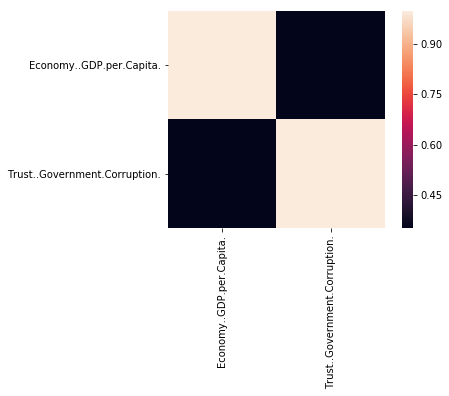

In [229]:
wh1 = wh[['Economy..GDP.per.Capita.','Trust..Government.Corruption.']] #Subsetting the data
cor = wh1.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

Мы получили тепловую карту корреляции между переменными. Чем светлее цвет на тепловой карте, тем выше зависимость. Можем заметить, что показатели счастья имеют сильную корреляцию с ВВП на душу населения, семьей и ожидаемой продолжительностью жизни и имеет наименьшую корреляцию с показателями щедрости. 

*Визуализация показателей счастья с использованием карты хороплет*

Выполним визуализацию показателей счастья различных стран на карте мира. Наведение мыши на страну покажет нам имя страны и значение показателя счастья для данной страны. 

In [230]:
#Ref: https://plot.ly/python/choropleth-maps/
data = dict(type = 'choropleth', 
           locations = wh['Country'],
           locationmode = 'country names',
           z = wh['Happiness.Score'], 
           text = wh['Country'],
           colorbar = {'title':'Happiness'})
layout = dict(title = 'Happiness Index 2017', 
             geo = dict(showframe = False, 
                       projection = {'type': 'Mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

**Кластеризация стран**

Мы рассматриваем восемь параметров, а именно: оценку счастья, ВВП на душу населения, семью, ожидаемую продолжительность жизни, свободу, щедрость, коррупцию и дистопию для кластеризации стран. Поскольку кластеризация чувствительна к диапазону данных, желательно масштабировать данные перед продолжением.

In [231]:
#Scaling of data
ss = StandardScaler()
ss.fit_transform(wh1)

array([[ 1.50618765,  1.90308437],
       [ 1.18651768,  2.73999784],
       [ 1.1823454 ,  0.30006609],
       [ 1.38344191,  2.40680857],
       [ 1.09398544,  2.56079976],
       [ 1.23792427,  1.57444226],
       [ 1.17893937,  1.62092002],
       [ 1.00370674,  2.56282438],
       [ 1.21513788,  2.57843667],
       [ 1.19136213,  1.75722637],
       [ 0.93141005, -0.37380164],
       [ 0.29799288, -0.22711087],
       [ 1.19775726,  0.96652596],
       [ 1.3388096 ,  0.12353995],
       [ 1.31365029,  1.72963811],
       [ 1.19972687,  1.51592295],
       [ 1.14216675,  1.26537256],
       [ 1.80535433,  1.93141289],
       [ 1.08936495,  1.40437027],
       [ 0.63911598, -0.40295446],
       [ 1.5297437 ,  1.98722085],
       [ 0.29238275, -0.11869343],
       [ 0.87728922, -0.85113462],
       [ 0.47821036, -0.62547117],
       [ 0.40165073,  0.09526981],
       [ 1.6869423 ,  3.36702216],
       [ 0.85487202,  0.29552172],
       [ 0.55513378,  0.54219374],
       [-0.26873475,

**Кластеризация k-средних**

В данном алгоритме необходимо пределить количество кластеров. Кластеры формируются на основе близости к центральному значению кластеров. Начальное значение центра выбирается случайным образом. Кластеризация K-средних - это подход сверху вниз, в том смысле, мы определяем количество кластеров (k), а затем группируем точки данных в k кластеров.

In [232]:
#K means Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, centroids = doKmeans(wh1, 3)
kmeans = pd.DataFrame(clust_labels)
wh1.insert((wh1.shape[1]),'kmeans',kmeans)
print(centroids)  
centers = np.array(centroids)
print(centers)


[[ 0.99323215  0.0856676 ]
 [ 0.40265771  0.10554677]
 [ 1.43055207  0.18390268]]
[[ 0.99323215  0.0856676 ]
 [ 0.40265771  0.10554677]
 [ 1.43055207  0.18390268]]


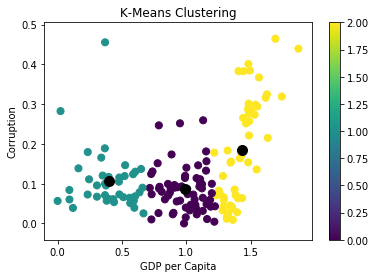

In [233]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wh1['Economy..GDP.per.Capita.'],wh1['Trust..Government.Corruption.'],
                     c=kmeans[0],s=50)
ax.scatter(centroids[:,0],centroids[:,1], color='black', s=100)  
ax.set_title('K-Means Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Corruption')
plt.colorbar(scatter)